In [35]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import os
import torch

from torch.utils.data import DataLoader

from src.deep_ad.config import Config
from src.deep_ad.data.dagm_split import dagm_patch_get_splits
from src.deep_ad.image import plot_losses, plot_images
from src.deep_ad.metrics import define_mse_metric, define_rmse_metric, define_psnr_metric
from src.deep_ad.model import DeepCNN
from src.deep_ad.save_manager import SaveManager
from src.deep_ad.trainer import Trainer, create_optimizer, PretrainedDict, define_loss_function
from src.deep_ad.transforms import create_training_transform, create_validation_transform, normalize_to_mean_std

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load the configuration
# config = Config(root_dir="..", config_path="../save/checkpoints/7_class_10_1_batch_weights_init/config.yml")
config = Config(root_dir="..", config_path="../default_config.yml")
config.train_classes = [10]

### Test the trainer

In [39]:
# Load the datasets
train_transform = create_training_transform(config)
val_transform = create_validation_transform(config)
train_dataset, val_dataset = dagm_patch_get_splits(config, train_transform, val_transform, classes=config.train_classes)

In [40]:
# Create the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

Create a new model

In [41]:
# Load the model
model = DeepCNN(config).to(config.device)
optimizer = create_optimizer(model, config)
model_num_params = sum(p.numel() for p in model.parameters())
print(f"Model has {model_num_params:,} parameters")
pretrained_dict = None

Model has 1,447,713 parameters


OR load a pretrained model

In [38]:
run_name = "13-7_class_10_1_batch_in_out_norm_lambda_31_32"
checkpoint_name = "best"
model = DeepCNN(config).to(config.device)
optimizer = create_optimizer(model, config)
checkpoint_path = SaveManager.get_checkpoint_path(config, run_name, name=checkpoint_name)
model, optimizer, train_losses, val_losses, epoch = SaveManager.load_checkpoint(
    model,
    optimizer,
    path=checkpoint_path,
    
)
pretrained_dict: PretrainedDict = {"epoch": epoch, "train_losses": train_losses, "val_losses": val_losses}

TypeError: SaveManager.get_checkpoint_path() got an unexpected keyword argument 'name'

In [42]:
# Create the trainer
run_name = f"13-e_class_10_10_batch_pad"
print(f"Run name: {run_name}\n")
train_epochs = 100
limit_batches = 1
save_epochs = [50, 100]
config.train_epochs = train_epochs
print(config)
trainer = Trainer(
    config,
    model,
    optimizer,
    train_dataloader,
    val_dataloader,
    run_name=run_name,
    train_epochs=train_epochs,
    limit_batches=limit_batches,
    shuffle_data=False,
    save_epochs=save_epochs,
    pretrained_dict=pretrained_dict or None,
)

Run name: 13-e_class_10_10_batch_pad

Datasets:
dagm_lengths: [0.8, 0.1, 0.1]
raw_patch_size: 176
patch_size: 128
ppi: 4
patches_iou_threshold: 0.05
patches_pad: False
patches_dataset_name: 

PyTorch:
seed: 42
device: cuda

Model:
batch_norm: True
init_weights: True

Training:
batch_size: 32
loss_type: l1_norm
loss_Lambda: 0.9
loss_N: 16384
optim_lr: 0.0002
optim_adam_betas: (0.9, 0.999)
optim_adam_eps: 1e-08
train_epochs: 100
train_classes: [10]

Detection:
center_size: 32
content_size: 24
stride: 16
hm_patch_size: 4
hm_threshold: 0.55


In [52]:
# Start training
%matplotlib inline
train_losses, val_losses = trainer.train(plot_period=10, plot_train=True, plot_val=True)

	Batch   1/100: Train Loss 0.000390, time 6.850 s
Epoch   1/100: Train Loss 0.000390, Val Loss 0.000449, time 7.867 s
Checkpoint saved at '..\save\checkpoints\13-e_class_10_10_batch_pad\best.pt'
	Batch   1/100: Train Loss 0.000371, time 5.488 s
Epoch   2/100: Train Loss 0.000371, Val Loss 0.000383, time 6.001 s
Checkpoint saved at '..\save\checkpoints\13-e_class_10_10_batch_pad\best.pt'
	Batch   1/100: Train Loss 0.000369, time 4.807 s
Epoch   3/100: Train Loss 0.000369, Val Loss 0.000369, time 5.256 s
Checkpoint saved at '..\save\checkpoints\13-e_class_10_10_batch_pad\best.pt'
	Batch   1/100: Train Loss 0.000311, time 4.901 s
Epoch   4/100: Train Loss 0.000311, Val Loss 0.000365, time 6.825 s
Checkpoint saved at '..\save\checkpoints\13-e_class_10_10_batch_pad\best.pt'


KeyboardInterrupt: 

In [27]:
# Clear cache after training
torch.cuda.empty_cache()

### Plots

In [65]:
# Load the best model
model_best = DeepCNN(config, old_architecture=False).to(config.device)
optimizer_best = create_optimizer(model_best, config)
run_name = "13_class_10_1_batch_winit_bn_inout_norm_all"
checkpoint_name = "epoch_100"
save_dir = os.path.join(config.root_dir, "save", "plots", run_name)
config.load(SaveManager.get_config_path(save_dir=config.save_dir, run_name=run_name))
model_best, optimizer_best, train_losses, val_losses, epoch = SaveManager.load_checkpoint(
    model=model_best,
    optimizer=optimizer_best,
    path=SaveManager.get_checkpoint_path(config, run_name=run_name, checkpoint_name=checkpoint_name),
)
print(f"Loading best model for run {run_name}, checkpoint {checkpoint_name}")
print(f"Epoch: {epoch + 1}")
print(f"Train loss: last={train_losses[-1]:.6f}, best={min(train_losses):.6f}")
print(f"Val loss: last={val_losses[-1]:.6f}, best={min(val_losses):.6f}")

Checkpoint loaded from '..\save\checkpoints\13_class_10_1_batch_winit_bn_inout_norm_all\epoch_100.pt'.
Loading best model for run 13_class_10_1_batch_winit_bn_inout_norm_all, checkpoint epoch_100
Epoch: 100
Train loss: last=0.000228, best=0.000228
Val loss: last=0.000231, best=0.000230


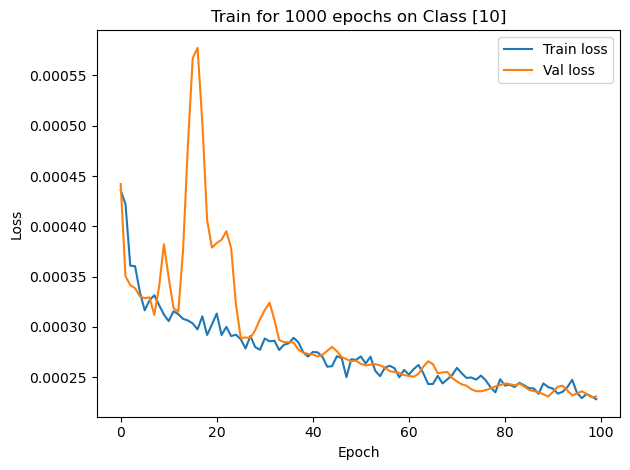

In [66]:
%matplotlib inline
# Plot the losses
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
train_classes_str = f'Class {config.train_classes}' if len(config.train_classes) > 0 else f"Classes {', '.join(map(str, config.classes))}"
plot_losses(
    torch.asarray(train_losses), 
    torch.asarray(val_losses), 
    title=f"Train for {1000} epochs on {train_classes_str}", 
    save_path=os.path.join(save_dir, f"{checkpoint_name}_losses.png"),
)

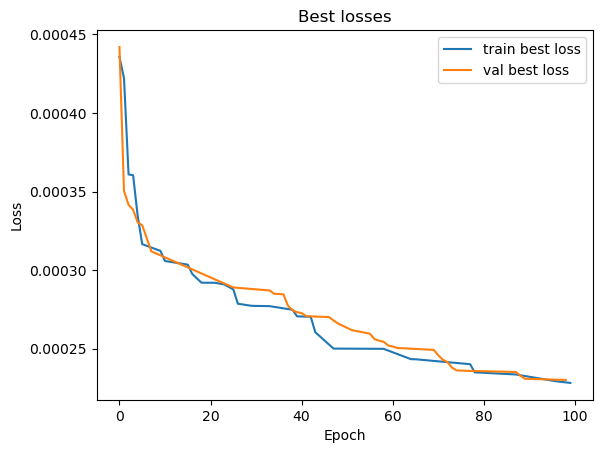

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

losses_minimum = np.minimum.accumulate(train_losses)
change_indices = (np.roll(losses_minimum, 1) != losses_minimum).nonzero()[0]
best_losses = np.array(train_losses)[change_indices]
val_losses_minimum = np.minimum.accumulate(val_losses)
val_change_indices = (np.roll(val_losses_minimum, 1) != val_losses_minimum).nonzero()[0]
best_val_losses = np.array(val_losses)[val_change_indices]

plt.plot(change_indices, best_losses, label="train best loss")
plt.plot(val_change_indices, best_val_losses, label="val best loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.title("Best losses")
plt.savefig(os.path.join(save_dir, f"{checkpoint_name}_best_losses.png"), dpi=1000)
plt.show()

Image #0: MSE 0.002984, RMSE 0.054624, PSNR 19.265656
Image #1: MSE 0.005166, RMSE 0.071872, PSNR 19.518671
Image #2: MSE 0.003310, RMSE 0.057536, PSNR 20.292400
Image #3: MSE 0.004986, RMSE 0.070615, PSNR 20.235310
losses: 142*10^-6, 226*10^-6, 230*10^-6, 389*10^-6


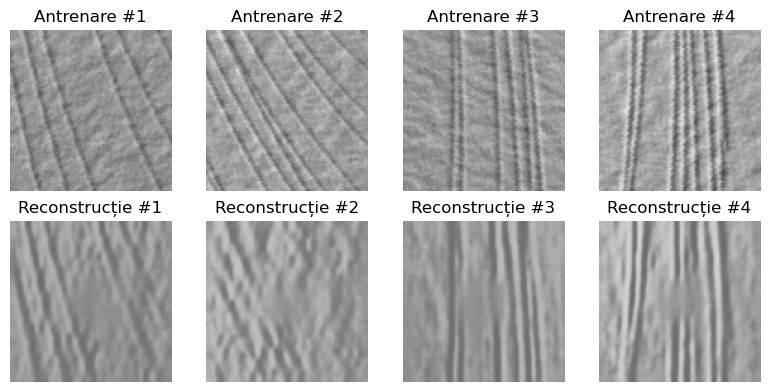

In [70]:
%matplotlib inline
# Load the datasets
train_transform = create_training_transform(config)
val_transform = create_validation_transform(config)
train_dataset, val_dataset = dagm_patch_get_splits(config, train_transform, val_transform, classes=[10])

# Create the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

def flatten(xs):
    return [x for ys in xs for x in ys]


loss_fn = define_loss_function(
    Lambda=config.loss_Lambda, mask=trainer.mask.cpu(), N=config.loss_N, loss_type=config.loss_type
)
mse_metric, rmse_metric, psnr_metric = define_mse_metric(), define_rmse_metric(), define_psnr_metric()
n_samples: int = 4
n_outputs: int = 2
dataset_type = "train"
dataset_type_ro = "antrenare" if dataset_type == "train" else "validare"
images, keys = next(iter(train_dataloader if dataset_type == "train" else val_dataloader))
input_images = []
masked_inputs = []
outputs = []
losses = []
for i in range(n_samples):
    image = images[i]
    input_images.append(image.squeeze().detach().cpu().numpy())
    input = image.unsqueeze(0).to(config.device)
    input = normalize_to_mean_std(input, mean=0.5267019737681685, std=0.19957033073362934)
    input[:, :, 48:80, 48:80] = 0
    masked_inputs.append(input.squeeze().detach().cpu().numpy())
    output = model_best(input)
    output = normalize_to_mean_std(
        output.cpu(), image.mean(dim=(-2, -1), keepdim=True), image.std(dim=(-2, -1), keepdim=True)
    )
    outputs.append(output.squeeze().detach().cpu().numpy())
    losses.append(loss_fn(output.cpu(), image.cpu().unsqueeze(0)).item())

    out, inp = torch.asarray(outputs[-1]), image.squeeze()
    mse, rmse, psnr = mse_metric(out, inp), rmse_metric(out, inp), psnr_metric(out, inp)
    print(f"Image #{i}: MSE {mse:.6f}, RMSE {rmse:.6f}, PSNR {psnr:.6f}")
diff = np.abs(np.array(input_images) - np.array(outputs))
# titles = flatten([[f"{dataset_type.capitalize()} #{i}", f"Masked #{i}", f"Output #{i}", f"Diff #{i}"] for i in range(4)])
# titles = flatten([[f"{dataset_type_ro.capitalize()} #{i + 1}", f"Reconstrucție #{i + 1}"] for i in range(n_samples)])
titles = flatten([[f"{dataset_type_ro.capitalize()} #{i + 1}" for i in range(n_samples)], [f"Reconstrucție #{i + 1}" for i in range(n_samples)]])
# titles = flatten([[f"{dataset_type_ro.capitalize()} #{i + 1}", f"Intrare #{i + 1}", f"Ieșire #{i + 1}", f"Diferență #{i + 1}"] for i in range(4)])
n_rows = n_outputs
n_cols = n_samples
plot_images(
    # flatten(list(zip(input_images, masked_inputs, outputs, diff))),
    # flatten(list(zip(input_images, outputs))),
    [*input_images, *outputs],
    titles,
    rows=n_rows,
    cols=n_cols,
    figsize=(n_cols * 2, n_rows * 2),
    show=False,
    range="01",
)
print(f"losses: {', '.join([f'{loss * 10 ** 6:.0f}*10^-6' for loss in losses])}")
plt.savefig(os.path.join(save_dir, f"{checkpoint_name}_{dataset_type}_outputs_paper.pdf"), bbox_inches="tight")
plt.show()

Checkpoint loaded from '..\save\checkpoints\13-e_class_10_10_batch_pad\epoch_1000.pt'.
Checkpoint loaded from '..\save\checkpoints\13-2_class_10_1_batch_winit_bn_inout_norm_all\epoch_1000.pt'.
13-e_class_10_10_batch_pad/epoch_1000:
train last: 0.000114, train best: 0.000113, val last: 0.000115, val best: 0.000114
13-2_class_10_1_batch_winit_bn_inout_norm_all/epoch_1000:
train last: 0.000130, train best: 0.000125, val last: 0.000146, val best: 0.000137


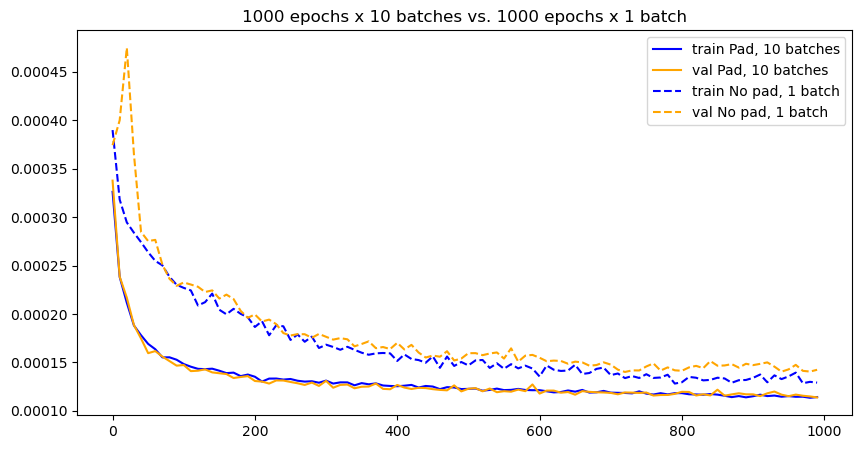

In [11]:
config.batch_norm = True
model1 = DeepCNN(config, old_architecture=False).to(config.device)
optimizer1 = create_optimizer(model1, config)
run_name1 = "13-e_class_10_10_batch_pad"
checkpoint_name1 = "epoch_1000"
model1, optimizer1, train_losses1, val_losses1, epoch1 = SaveManager.load_checkpoint(
    model=model1,
    optimizer=optimizer1,
    path=SaveManager.get_checkpoint_path(config, run_name=run_name1, checkpoint_name=checkpoint_name1),
)

config.batch_norm = True
model2 = DeepCNN(config, old_architecture=False).to(config.device)
optimizer2 = create_optimizer(model2, config)
run_name2 = "13-2_class_10_1_batch_winit_bn_inout_norm_all"
checkpoint_name2 = "epoch_1000"
model2, optimizer2, train_losses2, val_losses2, epoch2 = SaveManager.load_checkpoint(
    model=model2,
    optimizer=optimizer2,
    path=SaveManager.get_checkpoint_path(config, run_name=run_name2, checkpoint_name=checkpoint_name2),
)

print(f"{run_name1}/{checkpoint_name1}:")
print(
    f"train last: {train_losses1[-1]:.6f}, train best: {min(train_losses1):.6f}, val last: {val_losses1[-1]:.6f}, val best: {min(val_losses1):.6f}"
)
print(f"{run_name2}/{checkpoint_name2}:")
print(
    f"train last: {train_losses2[-1]:.6f}, train best: {min(train_losses2):.6f}, val last: {val_losses2[-1]:.6f}, val best: {min(val_losses2):.6f}"
)

import matplotlib.pyplot as plt

label1 = "Pad, 10 batches"
label2 = "No pad, 1 batch"
plt.figure(figsize=(10, 5))
step = 10
xs = list(range(len(train_losses1)))[::step]
plt.plot(xs, train_losses1[::step], label=f"train {label1}", color="blue")
plt.plot(xs, val_losses1[::step], label=f"val {label1}", color="orange")
plt.plot(xs, train_losses2[::step], label=f"train {label2}", color="blue", linestyle="--")
plt.plot(xs, val_losses2[::step], label=f"val {label2}", color="orange", linestyle="--")
plt.legend()
plt.title("1000 epochs x 10 batches vs. 1000 epochs x 1 batch")
plt.show()